In [153]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torchvision
from IPython.display import Image, display

In [154]:
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

In [155]:
# Hyperparameters
num_epochs = 30
batch_size = 100
learning_rate = 0.001

In [156]:
# Image processing modules
# ?
transform = transforms.Compose([
    transforms.Pad(4), # Adds a border (padding) of 4 pixels
    transforms.RandomHorizontalFlip(), # Randomly flips the image left ↔ right (mirror image)
    transforms.RandomCrop(32), # Randomly crops a 32×32 region from the image
    transforms.ToTensor()
])

In [157]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train = True,
                                             transform = transform, # the transform that has been defined above
                                             download = True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train = False,
                                            transform = transforms.ToTensor() # generalize for testing
                                           )  
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

Files already downloaded and verified


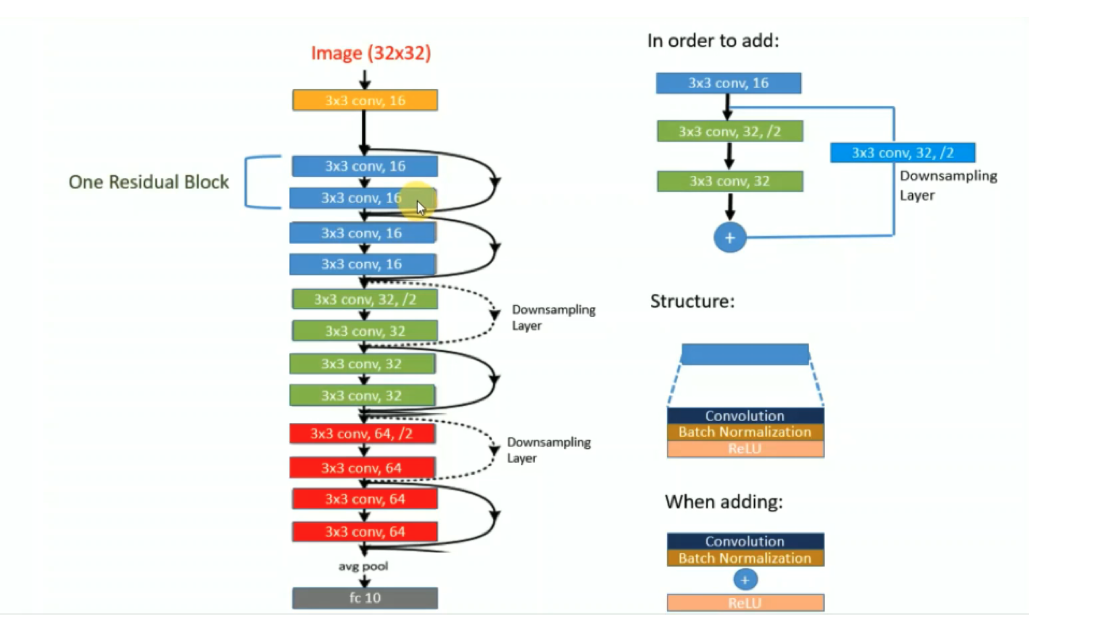

In [158]:
display(Image(filename="images/Resnet structure.png"))

### Convolution Parameters in ResNet

- **Stride**:  
  Stride = how many pixels the filter/kernel “moves” at each step when sliding across the image.  

- **In most ResNet architectures** (e.g., ResNet-18, ResNet-34, ResNet-50, etc.):
  - The **3×3 convolutions** inside the basic residual blocks usually have:
    ```python
    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    ```
    - Since `stride=1`, they **do NOT downsample** → the spatial resolution stays the same.  

  - When using:
    ```python
    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
    ```
    - This reduces the spatial resolution by **half** → **downsampling**.

---

- **Kernel size**:  
  - A **kernel (or filter)** is a small matrix of weights that slides over the image to extract features (edges, textures, patterns, etc.).  
  - `kernel_size=3` (or **3×3**) means the filter has shape **3 pixels × 3 pixels**.  
  - For each position, the convolution:
    1. Takes a **3×3 patch** of the input image,  
    2. Multiplies it elementwise with the **3×3 kernel weights**,  
    3. Sums them up,  
    4. Produces **1 number** for the output feature map.


In [160]:
def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
   
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsampling = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsampling = downsampling

    def forward(self, x):
        residual = x.clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsampling:
            residual = self.downsampling(x) 

        # downsampling could be defined as self.downsampling = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        # This is a 1×1 convolution with: in_channels = 64 out_channels = 128 kernel_size = 1 stride = 2
        # if Input x shape: [batch, 64, 32, 32] then Output of main path: [batch, 128, 16, 16]

        out += residual # it is += residual
        out = self.relu(out)

        return out

In [161]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self.make_layer(block, 16, layers[0], stride = 1) # layers will be a list [2,2,2]
        self.layer2 = self.make_layer(block, 32, layers[1], stride = 2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride = 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride = 1):
        # block: the class of residual block (ResidualBlock).
        # blocks: how many residual blocks to stack (e.g., 2 in your [2,2,2]).
        # e.g. model = ResNet(ResidualBlock, [2,2,2], num_classes=10)
        
        downsampling = None
        if (self.in_channels != out_channels) or (stride != 1):
            downsampling = nn.Sequential(conv3x3(self.in_channels, out_channels, stride = stride), nn.BatchNorm2d(out_channels))
        residual_blocks = []
        # First block can change channels / downsample
        residual_blocks.append(block(self.in_channels, out_channels, stride = stride, downsampling = downsampling))
        # update for subsequent block
        self.in_channels = out_channels
        residual_blocks.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*residual_blocks)
        
        
        # In ResNet, a “layer” (like layer1, layer2, layer3) is not a single conv — it’s a stack of residual blocks.
        # Example: ResNet-20 (for CIFAR-10) might have 3 layers:
        # layer1: 16 channels, 2 residual blocks
        # layer2: 32 channels, 2 residual blocks
        # layer3: 64 channels, 2 residual blocks
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out
        

Layer 1 is like

```
Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
    (bn1): BatchNorm2d(16)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
    (bn2): BatchNorm2d(16)
  )
  (1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
    (bn1): BatchNorm2d(16)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
    (bn2): BatchNorm2d(16)
  )
)
```

Layer 2 is like

```
Sequential(
  (0): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
    (bn1): BatchNorm2d(32)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
    (bn2): BatchNorm2d(32)
    (downsampling): Sequential(
      (0): Conv2d(16, 32, kernel_size=1, stride=2, bias=False)
      (1): BatchNorm2d(32)
    )
  )
  (1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
    (bn1): BatchNorm2d(32)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
    (bn2): BatchNorm2d(32)
  )
)
```


In [163]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [164]:
decay = 0

for epoch in range(num_epochs):
    model.train()
    
    # decay the learning rate by a factor of 0.5 every 20 epochs
    if (epoch + 1) % 20 == 0:
        decay += 1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5 ** decay)


    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 == 0:
            print("Epoch[{}/{}], Step[{}/{}] Loss:{:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Accuracy of the model on the test images: {} %".format(100 * correct / total))

    

Epoch[1/30], Step[100/500] Loss:1.6548
Epoch[1/30], Step[200/500] Loss:1.5280
Epoch[1/30], Step[300/500] Loss:1.1991
Epoch[1/30], Step[400/500] Loss:1.3471
Epoch[1/30], Step[500/500] Loss:1.0828
Epoch[2/30], Step[100/500] Loss:1.1488
Epoch[2/30], Step[200/500] Loss:1.0010
Epoch[2/30], Step[300/500] Loss:0.9220
Epoch[2/30], Step[400/500] Loss:1.0890
Epoch[2/30], Step[500/500] Loss:1.2227
Epoch[3/30], Step[100/500] Loss:0.7839
Epoch[3/30], Step[200/500] Loss:0.9319
Epoch[3/30], Step[300/500] Loss:0.8844
Epoch[3/30], Step[400/500] Loss:0.9772
Epoch[3/30], Step[500/500] Loss:0.8383
Epoch[4/30], Step[100/500] Loss:1.0151
Epoch[4/30], Step[200/500] Loss:0.7057
Epoch[4/30], Step[300/500] Loss:0.6837
Epoch[4/30], Step[400/500] Loss:0.7429
Epoch[4/30], Step[500/500] Loss:0.6887
Epoch[5/30], Step[100/500] Loss:0.6275
Epoch[5/30], Step[200/500] Loss:0.7838
Epoch[5/30], Step[300/500] Loss:0.9681
Epoch[5/30], Step[400/500] Loss:0.6378
Epoch[5/30], Step[500/500] Loss:0.5959
Epoch[6/30], Step[100/500